### Note: <br>
This code for the fine-tuning process of XLNet for hate speech detection is based on the following example, published on Medium: <br>

link to article: https://medium.com/swlh/using-xlnet-for-sentiment-classification-cfa948e65e85 <br>
author: Shanay Ghag <br>
published at: Jun 16, 2020<br>
link to GitHub: https://github.com/shanayghag/Sentiment-classification-using-XLNet

In [1]:
from datasets import load_dataset_builder, load_dataset
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import re

import sentencepiece
from collections import defaultdict

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler, Dataset, DataLoader
import torch.nn.functional as F
from keras.preprocessing.sequence import pad_sequences
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

In [2]:
# set up connection to drive: 
#from google.colab import drive
#drive.mount('/content/drive')

# define device: 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def prepare_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text) # remove @user 
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text) # remove links
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text) # remove smileys
    text = re.sub('#', '', text) # remove hash sign
    text = re.sub('\t', ' ',  text) # remove tab
    text = re.sub(r" +", ' ', text) # remove multiple whitespaces
    return text

# 1. Prepare Hate Dataset for Fine-Tuning

In [4]:
# load dataset from hugging face hub: tweets_hate_speech_detection
hate_data_train = load_dataset('tweets_hate_speech_detection', split='train')

Generating train split:   0%|          | 0/31962 [00:00<?, ? examples/s]

Dataset tweets_hate_speech_detection downloaded and prepared to /root/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2. Subsequent calls will reuse this data.


In [5]:
tweet = hate_data_train['tweet']
label = hate_data_train['label']
df_hate_1 = pd.DataFrame({'text': tweet, 'label': label}) # 0 = no hate; 1 = hate (racist or sexist)


In [6]:
# load different hate speech dataset:
hate_data_2= load_dataset('hate_speech_offensive', split='train')

Generating train split:   0%|          | 0/24783 [00:00<?, ? examples/s]

Dataset hate_speech_offensive downloaded and prepared to /root/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5. Subsequent calls will reuse this data.


In [7]:
text_2 = hate_data_2['tweet']
label_2 = hate_data_2['class']

df_hate_2 = pd.DataFrame({'text': text_2, 'label': label_2}) # 0 = hate-speech; 1 = offensive-language; 2 = neither

In [8]:
# change label to match df_hate_1 and binary classification: 0: no hate; 1: hate
df_hate_2.loc[(df_hate_2.label == 0),'label']=1 # change 0 to 1 to collapse hate speech and offensive language in one class
df_hate_2.loc[(df_hate_2.label == 2),'label']=0 # then change 2 to 0 to match df_hate_1 classes
# 0 = no hate; 1: hate 

In [9]:
df_hate = pd.concat([df_hate_1, df_hate_2])

In [10]:
df_test = df_hate[df_hate['label'] == 1]

In [11]:
# plot length of each tweet in order to determine max_length (must be done before sampling data)
# define tokenizer:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')


# count tokens per sentence
token_lens = []

for txt in df_hate['text']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


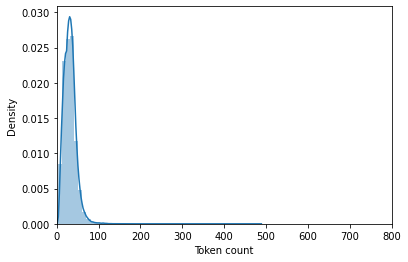

In [12]:
# plot
sns_plot = sns.distplot(token_lens)
plt.xlim([0, 800]);
plt.xlabel('Token count')

fig = sns_plot.get_figure()
fig.savefig('token_length_hate.png');

In [13]:
df_hate = shuffle(df_hate)
df_hate = df_hate[:24000]

In [14]:
df_hate['text'] = df_hate['text'].apply(prepare_text)
df_hate

,text,label
7138,So six martinis before passing out on the cou...,1
11251,social media can be used to uplift but it see...,0
18482,RT 1 A real nigga would NEVER be hurt and cryi...,1
29402,gentleman hqswag .. superstarking .. or ent.....,0
4869,the mayor is nothing like can't one defend ag...,0
...,...,...
18436,RT Bad bitch give me head like lice .,1
20129,RT My pussy popz Severely,1
14890,don't you want to come see this? it is amazing...,0
22691,watch elizabeth warren endorses hillary clinto...,0


non-hate tweets: 14225
hate tweets: 9775


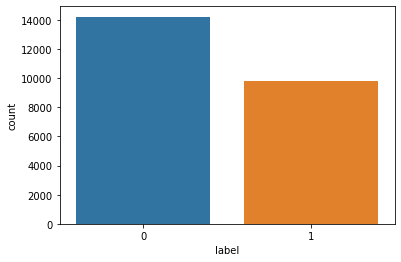

In [15]:
sns_plot = sns.countplot(x=df_hate.label) # to see class distribution
print(f'non-hate tweets: {len(df_hate[df_hate["label"] == 0])}')
print(f'hate tweets: {len(df_hate[df_hate["label"] == 1])}')

fig = sns_plot.get_figure()
fig.savefig('class_dist_hate.png');

In [16]:
class_names = ['no hate', 'hate']

In [17]:
df_hate.to_csv('test.csv')

# 2. Load XLNet, Prepare Inputs and Define Hyperparameter

In [18]:
# define max length: 
MAX_LEN = 512

In [19]:
# custom dataset class
class HateDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(review,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              truncation=True,
                                              return_token_type_ids=False,
                                              pad_to_max_length=False,
                                              return_attention_mask=True,
                                              return_tensors='pt',)
        
        input_ids = pad_sequences(encoding['input_ids'], 
                                  maxlen=MAX_LEN, 
                                  dtype=torch.Tensor ,
                                  truncating="post",
                                  padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 
        
        attention_mask = pad_sequences(encoding['attention_mask'], 
                                       maxlen=MAX_LEN, 
                                       dtype=torch.Tensor ,
                                       truncating="post",
                                       padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       
        
        return {'review_text': review,
                'input_ids': input_ids,
                'attention_mask': attention_mask.flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [20]:
# create training, validation and test set: 
df_train, df_test = train_test_split(df_hate, test_size=0.5, random_state=101)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=101)

In [21]:
# check shape
df_train.shape, df_val.shape, df_test.shape

((12000, 2), (6000, 2), (6000, 2))

In [22]:
# define custom dataloader:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = HateDataset(reviews=df.text.to_numpy(),
                     targets=df.label.to_numpy(),
                     tokenizer=tokenizer,
                     max_len=max_len)
    
    return DataLoader(ds,
                    batch_size=batch_size,
                    num_workers=2)                    

In [23]:
# define batch size: 
BATCH_SIZE = 8


# create data loader for training, validation and test set: 
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [24]:
# load pre-trained XLNet model
from transformers import XLNetForSequenceClassification

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
model = model.to(device)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [25]:
# defining hyperparameters:
EPOCHS = 2

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}]

optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [26]:
# sanity check: 
data = next(iter(val_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [27]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)

print(input_ids.reshape(8,512).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [28]:
outputs = model(input_ids.reshape(8,512), 
                token_type_ids=None, 
                attention_mask=attention_mask, 
                labels=targets)

In [29]:
type(outputs[0]) # should be torch.Tensor

torch.Tensor

In [30]:
# define training step function:
from sklearn import metrics

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].reshape(8,512).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
    
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]
    
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1
    
    return acc / counter, np.mean(losses)

In [31]:
# define evaluation function:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(8,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]
            
            # _, prediction = torch.max(outputs[1], dim=1)
            probs = F.softmax(outputs[1], dim=1)
            threshold = 0.99
            pred_thresh = []
            for i in probs:
                hatespeech_prob = i[1]
                if hatespeech_prob < threshold:
                    pred_thresh.append(0)
                elif hatespeech_prob >= threshold:
                    pred_thresh.append(1)
            prediction = torch.tensor(pred_thresh)
            
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)
            
            acc += accuracy
            losses.append(loss.item())
            counter += 1
            
    return acc / counter, np.mean(losses)

# 3. Fine-Tune the Model

In [32]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    # call train function
    train_acc, train_loss = train_epoch(model,
                                      train_data_loader,
                                      optimizer,
                                      device, 
                                      scheduler, 
                                      len(df_train))
    
    print(f'Train loss {train_loss} Train accuracy {train_acc}')
    
    # call evaluation function
    val_acc, val_loss = eval_model(model,
                                 val_data_loader, 
                                 device, 
                                 len(df_val))
    
    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'xlnet_model_hate.bin') # note: this scrip was implemented using Kaggle's GPU. The model was saved into the Kaggle repo and downloaded manually
        best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.28110919024364556 Train accuracy 0.9191666666666667
Val loss 0.2038224480965485 Val accuracy 0.9381666666666667

Epoch 2/2
----------
Train loss 0.15113896493803866 Train accuracy 0.9631666666666666
Val loss 0.21974863921365856 Val accuracy 0.9481666666666667

CPU times: user 44min 30s, sys: 8.06 s, total: 44min 38s
Wall time: 44min 56s


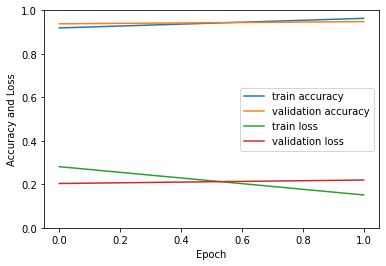

In [33]:
fig = plt.figure()
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
#plt.title('Training History')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
fig.savefig('training_hate.png');

# 4. Evaluation of Fine-Tuned Model

In [34]:
# read model saved in previous step:
# when connected to GPU:
model.load_state_dict(torch.load('xlnet_model_hate.bin'))

# when not connected to GPU (hence no cuda):
#model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/models/xlnet_model_hate.bin', map_location=torch.device('cpu')))

<All keys matched successfully>

In [35]:
model = model.to(device)

In [36]:
# call evaluation function and apply to test set
test_acc, test_loss = eval_model(model,
                                 test_data_loader,
                                 device,
                                 len(df_test))

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.9488333333333333
Test Loss : 0.23466799235995858


In [37]:
# define function to get prediction of data
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(8,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids,
                            token_type_ids=None,
                            attention_mask=attention_mask,#
                            labels=targets)
            
            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)
            probs = F.softmax(outputs[1], dim=1)
            threshold = 0.99
            pred_thresh = []
            for i in probs:
                hatespeech_prob = i[1]
                if hatespeech_prob < threshold:
                    pred_thresh.append(0)
                elif hatespeech_prob >= threshold:
                    pred_thresh.append(1)
            predictions.extend(torch.tensor(pred_thresh))
            review_texts.extend(texts)
            prediction_probs.extend(probs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return review_texts, predictions, prediction_probs, real_values

In [38]:
# call prediction function to get actual predictions of test set 
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [39]:
print(classification_report(y_test, y_pred, target_names=class_names))
report = classification_report(y_test, y_pred, target_names=class_names,output_dict=True)
report = pd.DataFrame(report).transpose()
report.to_csv('report_hate.csv')

              precision    recall  f1-score   support

     no hate       0.94      0.98      0.96      3555
        hate       0.97      0.90      0.93      2445

    accuracy                           0.95      6000
   macro avg       0.95      0.94      0.95      6000
weighted avg       0.95      0.95      0.95      6000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


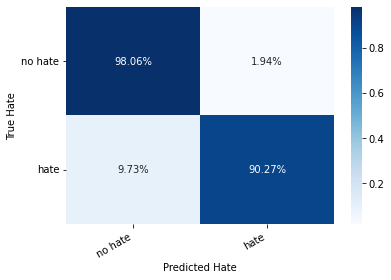

In [40]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix/ confusion_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

    plt.ylabel('True Hate')
    plt.xlabel('Predicted Hate')
    plt.savefig('confusion_hate');
    

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm.to_csv('cm_hate.csv')

show_confusion_matrix(df_cm)